# Housekeeping Settings

In [45]:
# env_path = /ocean/projects/cis240075p/asachan/.conda/envs/scvelo/bin/python

In [1]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, seaborn as sns
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/'
out_path = os.path.join(wd, 'out_data', 'sc_preproc')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

In [47]:

# sc.pp.highly_variable_genes(adata,flavor='cell_ranger',n_top_genes=3000)
# sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# sc.pp.scale(adata, max_value=10)
# sc.tl.pca(adata)
# sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
# sc.pp.neighbors(adata)
# sc.pl.umap(adata, color=['leiden'], legend_loc='on data')
# sc.pl.embedding(adata, basis='X_pca', color=['leiden'], legend_loc='on data')


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


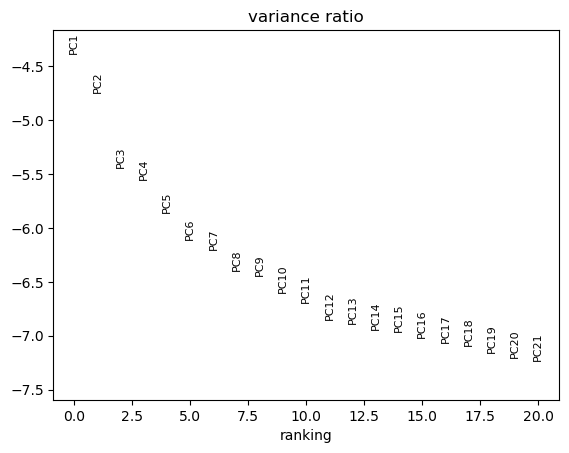

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


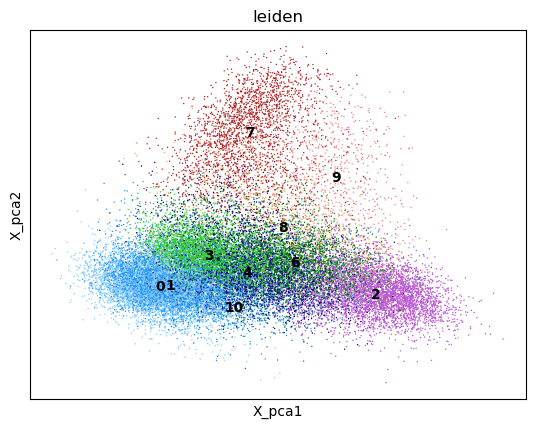

In [2]:
path_to_adata = f'{out_path}/out_files/male_sc_processed.h5ad'
adata = sc.read_h5ad(path_to_adata) #os.path.join(wd, 'out_data','out_other_methods/donor1_multiome_gex_post_mira.h5ad'))
adata = adata[:, adata.var.highly_variable]
adata = adata[adata.obs['cell_type_annotation'] != 't_cells']
adata = adata[adata.obs['cell_type_annotation'] != 'Naive']
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
sc.pl.embedding(adata, basis='X_pca', color=['leiden'], legend_loc='on data')

In [3]:
print(adata.X.shape)
print(adata.layers['counts'].shape)
print(adata.X.max())
print(adata.X.min())

(29493, 4142)
(29493, 4142)
10.0
-7.842723


In [5]:
adata.obs['leiden'].unique()

['3', '1', '0', '8', '6', '2', '7', '4', '9', '10']
Categories (10, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

In [4]:
adata.uns['leiden_colors']

array(['lightskyblue', 'dodgerblue', 'mediumorchid', 'limegreen',
       'darkblue', 'green', 'firebrick', 'sandybrown', 'lightcoral',
       'teal'], dtype=object)

# Run Palantir

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


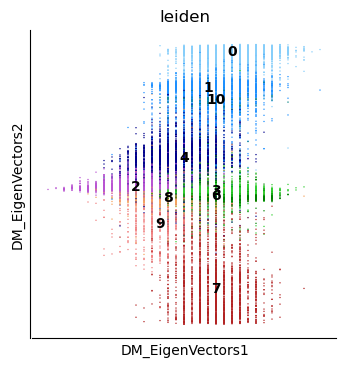

array([[0.        , 0.        , 0.02870643, ..., 0.2042236 , 0.04034688,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16219075,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01912407,
        0.13814406],
       [0.        , 0.02550558, 0.0346116 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [50]:
import palantir
# Impute only highly variable genes by using diffusion in the pca space of cells to get new nearest neighbors
palantir.utils.run_diffusion_maps(adata,n_components=50) #n_components, select from the plot above, knn = 30 by default for graph construction
sc.pl.embedding(adata, basis='DM_EigenVectors', color=['leiden'], legend_loc='on data')
palantir.utils.run_magic_imputation(adata) # Run Imputation
# adata.write(f'{out_path}/out_files/male_sc_processed_rna_imputed.h5ad')

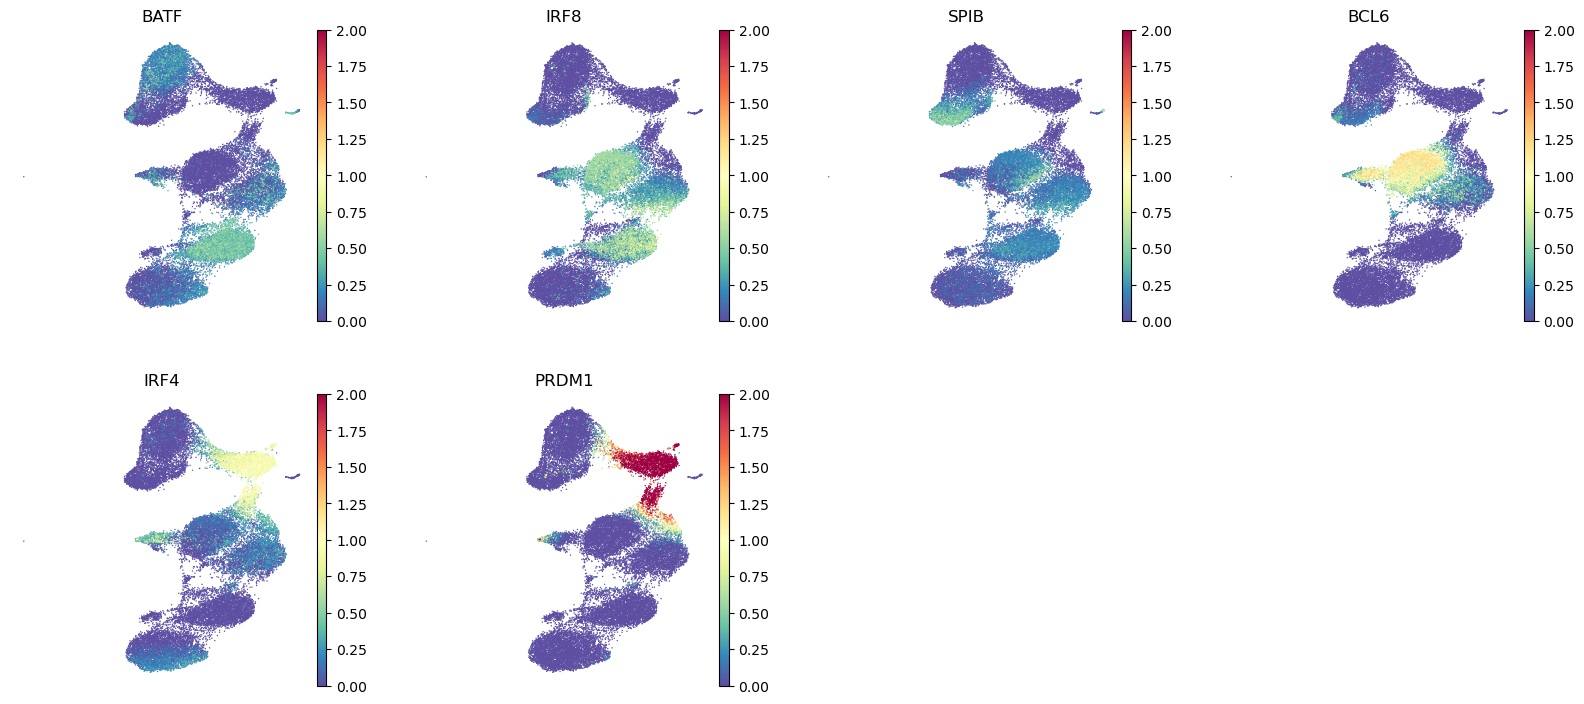

In [51]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()


# Filter cells for stream input

In [52]:
adata.obs['cell_type_annotation']

AAACAGCCAAGCCACT-3              GC_1
AAACAGCCAAGGTGCA-1            ActB_2
AAACAGCCAAGTTATC-1            ActB_1
AAACAGCCAATAGCCC-1            ActB_1
AAACAGCCAATTATGC-2    unknown_rpl_hi
                           ...      
TTTGTTGGTTTACGTC-1            ActB_1
TTTGTTGGTTTAGTCC-1            ActB_1
TTTGTTGGTTTATGGG-2            ActB_3
TTTGTTGGTTTCCTCC-3              GC_2
TTTGTTGGTTTGAGGC-2            ActB_3
Name: cell_type_annotation, Length: 29493, dtype: category
Categories (10, object): ['ActB_1', 'ActB_2', 'ActB_4', 'GC_1', ..., 'PB_1', 'unknown_rpl_hi', 'early_PB', 'early_ActB']

In [53]:
# subset the anndata to only include the cells that are in the categories of interest
adata=adata[adata.obs['cell_type_annotation'].isin(['ActB_1', 'ActB_2', 'ActB_3', 'ActB_4', 'GC_1',
       'GC_2', 'PB_1', 'early_ActB', 'early_PB'])]
adata.write(f'{out_path}/out_files/stream_input_filtered_cells.h5ad')